<a href="https://colab.research.google.com/github/ZzangJay/team_project/blob/main/20221105_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
#import tensorflow as tf 
import os
import sys
from datetime import datetime, timedelta
from tqdm.autonotebook import tqdm
import csv
import re
import gzip
import shutil

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [2]:
from google.colab import drive  # for colab
drive.mount('/content/gdrive/')  # for colab
cloud_directory = '/content/gdrive/MyDrive/mimiciv_unzip/'
os.listdir(cloud_directory) # for colab, check cloud directory mount

Mounted at /content/gdrive/


['CHANGELOG.txt',
 'LICENSE.txt',
 'SHA256SUMS.txt',
 'index.html',
 'icu',
 'hosp',
 'drop_2_chartevents.csv']

In [3]:
admission = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/hosp/admissions.csv', low_memory=False, dtype='str', keep_default_na=False)
patients = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/hosp/patients.csv', low_memory=False, dtype='str', keep_default_na=False)
diagnoses_icd = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/hosp/diagnoses_icd.csv', low_memory=False, dtype='str', keep_default_na=False)
icustays = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/icu/icustays.csv', low_memory=False, dtype='str', keep_default_na=False)
sepsis = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/sepsis3.csv', low_memory=False, dtype='str', keep_default_na=False)

In [4]:
admission = pd.merge(left = admission, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')
patients = pd.merge(left = patients, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')
diagnoses_icd = pd.merge(left = diagnoses_icd, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')
sepsis = pd.merge(left = sepsis, right = icustays[['hadm_id','stay_id']], how='left', left_on='stay_id', right_on='stay_id')

In [5]:
Total_HADMIDS = set(sepsis['hadm_id'])

In [6]:
feature_keys = ['FiO2', 'HR', 'PaO2', 'SBP', 'Temperature','Creatinine','Glucose', 'Hb', 'Lactate', 'Plt','Sodium' ,'WBC']

In [7]:
EXTRACT_FEATURE_CODES_VS = dict({
    '226754': 'FiO2', '223835': 'FiO2', '227010': 'FiO2', '229280':'FiO2', '229841': 'FiO2',
    '220045': 'HR', '220046': 'HR', '226764': 'HR', '227018': 'HR',
    '220224': 'PaO2', '227039': 'PaO2', '227516': 'PaO2',
    '220050': 'SBP' ,'220179': 'SBP', '224167': 'SBP', '227243': 'SBP', '228152': 'SBP',
    '223762': 'Temperature', '226329': 'Temperature', '227632': 'Temperature', '227634': 'Temperature',
    })
EXTRACT_FEATURE_CODES_LAB = dict({
    '220615': 'Creatinine', '229761': 'Creatinine',
    '220621': 'Glucose', '225664': 'Glucose', '226537': 'Glucose',
    '220228': 'Hb',
    '225668': 'Lactate',
    '227457': 'Plt',
    '220645': 'Sodium', '226534': 'Sodium',
    '220546': 'WBC'}) 
EXTRACT_FEATURE_CODES_NORMAL = dict({
        'FiO2': [10, 100],
        'HR': [30, 200],
        'PaO2': [50, 200],
        'SBP': [40, 250],
        'Temperature': [30, 45],
        'Creatinine': [0.2, 100],
        'Glucose': [30, 1000],
        'Hb': [5, 20],
        'Lactate': [0.5, 2.5],
        'Plt': [10, 500],
        'Sodium': [90, 170],
        'WBC': [1, 30]
})
NORMAL_VALUE = dict({
        'FiO2': 40,
        'HR': 75, #(50+100)/2
        'PaO2': 87.5, #(75+100)/2
        'SBP': 115, #(90+140)/2 = 115
        'Temperature': 36.65, #(36.1+37.2)/2
        'Creatinine': 1.0, #(0.7+1.0)/2
        'Glucose': 100, #(60+140)/2
        'Hb': 15.0, #(13.8+17.2)/2
        'Lactate': 1.35, #(0.5+2.2)/2 = 1.35
        'Plt': 270, #(140+400)/2
        'Sodium': 140, #(135+145)/2
        'WBC': 7.5 #(5+10)/2
})

# EXTRACT_FEATURE_CODES_anti = ('225798','225837','225838','225840','225842','225843','225844','225845','225847','225848','225850','225851','225853','225855','225857','225859','225860','225862','225863','225865','225866','225868','225869','225871','225873','225875','225876','225877','225879','225881','225882','225883','225884','225885','225886','225888','225889','225890','225892','225893','225895','225896','225897','225898','225899','225900','225902','225903','225905','227691','228003','229059','229061','229064','229587')
# EXTRACT_FEATURE_CODES_ANTI_2 = dict({
#    '225850': 'Cephalosporin', '225851': 'Cephalosporin', '225853': 'Cephalosporin', '225855': 'Cephalosporin', '229587':'Cephalosporin',
#    '225798': 'Glycopetide',
#    '225842': 'Penicillin', '225843': 'Penicillin', '225888': 'Penicillin', '225889': 'Penicillin', '225890': 'Penicillin', '225892': 'Penicillin', '225893': 'Penicillin',
#    '225859': 'Quninolone', '225859': 'Quninolone', '225879': 'Quninolone', '225886': 'Quninolone',
#    '225845': 'Macrolide', '225865': 'Macrolide', '225866': 'Macrolide'
# })

In [8]:
## Define some util functions
NOT_CONVERTED = 'NOT_CONVERTED'
## 문자로 기록된 날짜 값들을 파이썬의 datetime 데이터로 바꿔주는 함수 작성
def str2datetime(s):
    def _convert(_s, _dformat):
        try:
            converted_dt = datetime.strptime(_s, _dformat)
        except Exception:
            return NOT_CONVERTED

        return converted_dt

    if isinstance(s, datetime):
        return s

    dformats = [
        '%Y-%m-%d %p %I:%M:%S',
        '%Y-%m-%d %H:%M:%S.%f',
        '%Y-%m-%d %H:%M:%S',
        '%Y-%m-%d %H:%M',
        '%y-%m-%d %H:%M',
        '%Y-%m-%d',
        '%Y%m%d',
        '%Y-%m-%d +%H:%M',
        '%Y%m%d %H%M',
        '%Y%m%d%H%M%S',
        ]

    s = s.split('.')[0]
    s = s.replace('오전', 'am').replace('오후', 'pm')
    for dformat in dformats:
        dt = _convert(s, dformat)
        if dt != NOT_CONVERTED:
            return dt

    return NOT_CONVERTED

In [9]:
def extract_features():
  features_hadm_id = dict()
  chartevents = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_unzip/icu/chartevents.csv', 'r', encoding='utf-8'))
  labevents = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_unzip/hosp/labevents.csv', 'r', encoding='utf-8'))
  for row in tqdm(chartevents, desc='Extract_VS', total=329822285, ncols=700):
    if row['hadm_id'] in Total_HADMIDS:
      hadm_id = row['hadm_id']
      features_hadm_id[hadm_id] = features_hadm_id.get(hadm_id, dict()) #get 없으면 2번째로 return

      item_id = row['itemid']
      if item_id not in EXTRACT_FEATURE_CODES_VS:
        continue
      item_name = EXTRACT_FEATURE_CODES_VS[item_id]
      try:
        #정규식을 이용해서 기록된 값에서 숫자 형태의 값만 가져오기
        #소수점 둘째자리 까지만 값을 사용하기
        item_value = round(float(re.findall("\d+\.\d+|\d+", row['valuenum'])[0]), 2)
      except Exception:
        continue
      
      item_time = str2datetime(row['charttime'])
      if item_time == NOT_CONVERTED:
        continue
      #GCP total score도 시간대에 총합으로 사용함
      if item_name == 'TEMP_F':
        item_value = round((item_value - 32.0) / 1.8, 2)
        item_name = 'TEMP'

    #   if item_value > FEATURE_NORMAL_RANGE[item_name][1]:
    #     item_value = FEATURE_NORMAL_RANGE[item_name][1]
    #   elif item_value < FEATURE_NORMAL_RANGE[item_name][0]:
    #     item_value = FEATURE_NORMAL_RANGE[item_name][0]

      features_hadm_id[hadm_id][item_name] = features_hadm_id[hadm_id].get(item_name, list()) #같은 환자의 여러개 feature가 있으면 list로 반환하도록
      features_hadm_id[hadm_id][item_name].append((item_time, item_value))
      
    else:
      continue

  for row in tqdm(labevents, desc='Extract_LAB', total=124342638, ncols=700):
    if row['hadm_id'] in Total_HADMIDS:
      hadm_id = row['hadm_id']
      features_hadm_id[hadm_id] = features_hadm_id.get(hadm_id, dict())

      item_id = row['itemid']
      if item_id not in EXTRACT_FEATURE_CODES_LAB:
        continue
      item_name = EXTRACT_FEATURE_CODES_LAB[item_id]
      try:
        #정규식을 이용해서 기록된 값에서 숫자 형태의 값만 가져오기
        #소수점 둘째자리 까지만 값을 사용하기
        item_value = round(float(re.findall("\d+\.\d+|\d+", row['valuenum'])[0]), 2)
      except Exception:
        continue
      
      item_time = str2datetime(row['charttime'])
      if item_time == NOT_CONVERTED:
        continue

      #if item_value > FEATURE_NORMAL_RANGE[item_name][1]:
      #  item_value = FEATURE_NORMAL_RANGE[item_name][1]
      #elif item_value < FEATURE_NORMAL_RANGE[item_name][0]:
      #  item_value = FEATURE_NORMAL_RANGE[item_name][0]
        
      features_hadm_id[hadm_id][item_name] = features_hadm_id[hadm_id].get(item_name, list())
      features_hadm_id[hadm_id][item_name].append((item_time, item_value))
      
    else:
      continue
      
  return features_hadm_id

In [ ]:
# extracted_features = extract_features()

In [10]:
import pickle
import gzip

In [ ]:
# with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/extracted_features.pickle', 'wb') as f:
#     pickle.dump(extracted_features, f)

In [11]:
with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/extracted_features.pickle','rb') as f:
    extracted_features = pickle.load(f)

In [12]:
# 사망 레이블 하기
death_labels = dict()
admissions = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_der/sepsis3_admissions.csv', 'r', encoding='utf-8'))
for row in tqdm(admissions, desc='Get Death Label'):
  hadm_id = row['hadm_id']
  death_yn = int(row['hospital_expire_flag'])
  if death_yn:
    event_time = str2datetime(row['deathtime'])
  else:
    event_time = str2datetime(row['dischtime'])
  death_labels[hadm_id] = dict({'DEATH': death_yn, 'EVENT_TIME': event_time})

Get Death Label: 0it [00:00, ?it/s]

In [13]:
# 재실 기간 레이블 하기
los_labels = dict()
admissions = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_der/sepsis3_admissions.csv', 'r', encoding='utf-8'))
for row in tqdm(admissions, desc='Get loss Label'):
  hadm_id = row['hadm_id']
  admin_time = str2datetime(row['admittime'])
  disc_time = str2datetime(row['dischtime'])
  los = (disc_time - admin_time).total_seconds() / (60*60)
  los_labels[hadm_id] = int(los)

Get loss Label: 0it [00:00, ?it/s]

In [14]:
## 환자의 입실 퇴실 시간 정보 가져오기
Extracted_HADMIDS = list(extracted_features.keys())
admin_disc_time = dict()

admissions = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_der/sepsis3_admissions.csv', 'r', encoding='utf-8'))
for row in admissions:
  hadm_id = row['hadm_id']
  admin_time = str2datetime(row['admittime'])
  disc_time = str2datetime(row['dischtime'])

  if (admin_time != NOT_CONVERTED) and (disc_time != NOT_CONVERTED):
    admin_disc_time[hadm_id] = dict({'ADMIN': admin_time, 'DISC': disc_time})

In [15]:
## 입실 시점으로부터 1시간 간격으로 데이터를 읽어오는 함수 정의
def quantize_features(feature_list, admin_time, disc_time, missing_feature=False):
  total_hours = int((disc_time - admin_time).total_seconds() / (60*60))
  #입실 이후 최대 24시간 동안의 데이터만 가져오기
  if total_hours > 24:
    total_hours = 24
  
  quantized_features = list()
  if missing_feature:
    for i in range(total_hours):
      quantized_time = admin_time + timedelta(hours=i)
      quantized_value = np.nan #지금은 dic 형태라, pandas 쓰면 NAN이랑 동일, carry forward 도 가능
      quantized_features.append((quantized_time, quantized_value))
  else:
    feature_list = list(sorted(feature_list, key=lambda x: x[0]))
    for i in range(total_hours):
      quantized_time = admin_time + timedelta(hours=i)
      quantized_time_start = quantized_time - timedelta(hours=1)
      quantized_values = list(filter(lambda x: quantized_time_start < x[0] <= quantized_time, feature_list)) #filter함수 True만 필터
      if len(quantized_values) > 0:
        quantized_value = quantized_values[-1][1]
      else:
        quantized_value = np.nan 

      quantized_features.append((quantized_time, quantized_value))
  
  return quantized_features

In [16]:
## 전체 데이터에 대해서 데이터 변환하기
quantized_features = dict()
for hadm_id in tqdm(Extracted_HADMIDS, desc='Doing Quantization'):
    admin_time = admin_disc_time[hadm_id]['ADMIN']
    disc_time = admin_disc_time[hadm_id]['DISC']
    if (disc_time - admin_time).total_seconds() / (60*60) < 1.0:
      continue
    quantized_features[hadm_id] = dict()
    for kk in feature_keys:
      if kk in extracted_features[hadm_id]:
        feature_list = extracted_features[hadm_id][kk]
        quantized_features[hadm_id][kk] = quantize_features(feature_list, admin_time, disc_time)
      else:
        quantized_features[hadm_id][kk] = quantize_features(None, admin_time, disc_time, missing_feature=True)


Doing Quantization:   0%|          | 0/32812 [00:00<?, ?it/s]

In [17]:
def carry_forward(feature_name, feature_list):
  imputed_features = list()
  for i, (feature_t, feature_v) in enumerate(feature_list):
    if np.isnan(feature_v):
      last_observations = list(filter(lambda x: (x[0] <= feature_t) and (not np.isnan(x[1])), feature_list))
      if len(last_observations) > 0:
        imputed_features.append((feature_t, last_observations[-1][1]))
      else:
        imputed_features.append((feature_t, NORMAL_VALUE[feature_name]))
    else:
      imputed_features.append((feature_t, feature_v))

  return imputed_features

In [18]:
Quantized_HADMIDS = list(quantized_features.keys())
carry_forwarded_features = dict()
for hadm_id in tqdm(Quantized_HADMIDS, desc='Carry-Forward'):
  carry_forwarded_features[hadm_id] = dict()

  for kk in feature_keys:
    feature_list = quantized_features[hadm_id][kk]
    carry_forwarded_features[hadm_id][kk] = carry_forward(kk, feature_list)

Carry-Forward:   0%|          | 0/32785 [00:00<?, ?it/s]

In [19]:
#Min-Max Normalization
min_max_normalized = dict()
for hadm_id in tqdm(Quantized_HADMIDS, desc='Min-Max Normalization', ncols=700):
  min_max_normalized[hadm_id] = dict()
  for kk in feature_keys:
    features = np.array(carry_forwarded_features[hadm_id][kk])

    min = EXTRACT_FEATURE_CODES_NORMAL[kk][0]
    max = EXTRACT_FEATURE_CODES_NORMAL[kk][1]

    features[:, 1] = (features[:, 1] - min) / (max - min)
    min_max_normalized[hadm_id][kk] = features

Min-Max Normalization:   0%|                                                                                  …

In [20]:
total_death_included_hadm_ids = list(death_labels.keys())
total_los_included_hadm_ids = list(los_labels.keys())

In [21]:
## 사망 예측용 데이터
death_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

for hadm_id in tqdm(total_death_included_hadm_ids, desc='Make Death Dataset', ncols=700):
  if hadm_id not in min_max_normalized:
    continue
  if len(min_max_normalized[hadm_id][feature_keys[0]]) >= 24:
    time_len = 24
  else:
    time_len = len(min_max_normalized[hadm_id][feature_keys[0]])
  
  try:
    data = np.array(min_max_normalized[hadm_id][feature_keys[0]])[:time_len, 1].reshape(time_len, 1)
  except:
    continue

  for kk in feature_keys[1:]:
    data = np.concatenate((data, np.array(min_max_normalized[hadm_id][kk])[:time_len, 1].reshape(time_len, 1)), axis=1)
  
  death_dataset['HADM_IDS'].append(hadm_id)
  death_dataset['LABEL'].append(death_labels[hadm_id]['DEATH'])
  death_dataset['DATA'].append(data)

Make Death Dataset:   0%|                                                                                     …

In [22]:
id_cepha = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/temp/id_cepha.csv', low_memory=False, dtype='str', keep_default_na=False)
id_glyco = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/temp/id_glyco.csv', low_memory=False, dtype='str', keep_default_na=False)
id_peni = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/temp/id_peni.csv', low_memory=False, dtype='str', keep_default_na=False)
id_fluoro = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/temp/id_fluoro.csv', low_memory=False, dtype='str', keep_default_na=False)
id_macro = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/temp/id_macro.csv', low_memory=False, dtype='str', keep_default_na=False)

In [23]:
len(death_dataset['HADM_IDS'])

32785

In [24]:
cepha_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

glyco_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

peni_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

fluoro_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

macro_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

In [25]:
list_glyco=[]
for i in id_glyco['hadm_id']:
  list_glyco.append(i)

list_cepha=[]
for i in id_cepha['hadm_id']:
  list_cepha.append(i)

list_peni=[]
for i in id_peni['hadm_id']:
  list_peni.append(i)

list_fluoro=[]
for i in id_fluoro['hadm_id']:
  list_fluoro.append(i)

list_macro=[]
for i in id_macro['hadm_id']:
  list_macro.append(i)


In [26]:
for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Glycopeptides Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_glyco) == True:
      glyco_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      glyco_dataset['LABEL'].append(death_dataset['LABEL'][i])
      glyco_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Cephalosporins Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_cepha) == True:
      cepha_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      cepha_dataset['LABEL'].append(death_dataset['LABEL'][i])
      cepha_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Penicillins Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_peni) == True:
      peni_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      peni_dataset['LABEL'].append(death_dataset['LABEL'][i])
      peni_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Fluoroquinolones Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_fluoro) == True:
      fluoro_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      fluoro_dataset['LABEL'].append(death_dataset['LABEL'][i])
      fluoro_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Macrolides Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_macro) == True:
      macro_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      macro_dataset['LABEL'].append(death_dataset['LABEL'][i])
      macro_dataset['DATA'].append(death_dataset['DATA'][i])

print(len(glyco_dataset['HADM_IDS']))
print(len(cepha_dataset['HADM_IDS']))
print(len(peni_dataset['HADM_IDS']))
print(len(fluoro_dataset['HADM_IDS']))
print(len(macro_dataset['HADM_IDS']))

Make Glycopeptides Dataset:   0%|                                                                             …

Make Cephalosporins Dataset:   0%|                                                                            …

Make Penicillins Dataset:   0%|                                                                               …

Make Fluoroquinolones Dataset:   0%|                                                                          …

Make Macrolides Dataset:   0%|                                                                                …

11754
10954
6062
3653
1919


In [27]:
## 재실기간 예측용 데이터
los_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

for hadm_id in tqdm(total_los_included_hadm_ids, desc='Make LOS Dataset', ncols=700):
  time_len = 12
  
  try:
    data = np.array(min_max_normalized[hadm_id][feature_keys[0]])[:time_len, 1].reshape(time_len, 1)
  except:
    continue

  for kk in feature_keys[1:]:
    data = np.concatenate((data, np.array(min_max_normalized[hadm_id][kk])[:time_len, 1].reshape(time_len, 1)), axis=1)
  
  los_dataset['HADM_IDS'].append(hadm_id)
  los_dataset['LABEL'].append(los_labels[hadm_id])
  los_dataset['DATA'].append(data)

Make LOS Dataset:   0%|                                                                                       …

## train-test 분할

In [28]:
## 학습용 검증용 데이터 나누기 (8:2)
def split_train_test(dataset, train_ratio=0.8, pos_neg=True):
  #레이블이 양성, 음성인 경우, 학습 데이터, 테스트 데이터를 나눌 때 
  #양성, 음성의 비율을 각각 유지할 수 있도록 구현
  if pos_neg:
    pos_idx = np.where(np.array(dataset['LABEL']) == 1)[0]
    neg_idx = np.where(np.array(dataset['LABEL']) == 0)[0]

    # suffle 넣어줘서 index 섞어줘야함. np.random, random,suffle
    np.random.shuffle(pos_idx)
    np.random.shuffle(neg_idx)

    pos_num = len(pos_idx)
    neg_num = len(neg_idx)

    train_pos_idx = list(pos_idx[:int(pos_num * train_ratio)])
    test_pos_idx = list(pos_idx[int(pos_num * train_ratio):])

    train_neg_idx = list(neg_idx[:int(neg_num * train_ratio)])
    test_neg_idx = list(neg_idx[int(neg_num * train_ratio):])

    train_idx = train_pos_idx + train_neg_idx
    test_idx = test_pos_idx + test_neg_idx
  
  #레이블이 양성, 음성이 아닌경우 단순하게 전체 데이터에서 학습, 테스트 비율만큼 나누기
  else:
    idx = np.arange(len(dataset['LABEL']))
    np.random.shuffle(idx)
    train_idx = idx[:int(len(idx) * train_ratio)]
    test_idx = idx[int(len(idx) * train_ratio):]

  train_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[train_idx],
      'LABEL': np.array(dataset['LABEL'])[train_idx],
      'DATA': np.array(dataset['DATA'])[train_idx]
  })

  test_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[test_idx],
      'LABEL': np.array(dataset['LABEL'])[test_idx],
      'DATA': np.array(dataset['DATA'])[test_idx]
  })
  return train_set, test_set

In [29]:
death_train, death_test = split_train_test(death_dataset)
los_train, los_test = split_train_test(los_dataset, pos_neg=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [30]:
print(len(death_train['HADM_IDS']))
print(len(death_test['HADM_IDS']))
print(len(los_train['HADM_IDS']))
print(len(los_test['HADM_IDS']))

26227
6558
26072
6519


In [31]:
cepha_train, cepha_test = split_train_test(cepha_dataset)
glyco_train, glyco_test = split_train_test(glyco_dataset)
peni_train, peni_test = split_train_test(peni_dataset)
fluoro_train, fluoro_test = split_train_test(fluoro_dataset)
macro_train, macro_test = split_train_test(macro_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [32]:
print(len(glyco_train['HADM_IDS']))
print(len(glyco_test['HADM_IDS']))
print(len(cepha_train['HADM_IDS']))
print(len(cepha_test['HADM_IDS']))
print(len(peni_train['HADM_IDS']))
print(len(peni_test['HADM_IDS']))
print(len(fluoro_train['HADM_IDS']))
print(len(fluoro_test['HADM_IDS']))
print(len(macro_train['HADM_IDS']))
print(len(macro_test['HADM_IDS']))

9402
2352
8762
2192
4849
1213
2922
731
1534
385


## 모델 학습 


In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from tensorflow.keras.utils import Sequence
import numpy as np

In [34]:
## 사망예측 모델용 데이터 로더
class Death_Dataloader(Sequence):
    def __init__(self, x_set, y_set, hadm_id_set, batch_size, shuffle=False):
        self.x, self.y, self.hadm_id = x_set, y_set, hadm_id_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

		# batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
		# sampler의 역할(index를 batch_size만큼 sampling해줌)
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        ## 입력 데이터들의 크기를 최대 24시간으로 통일하고 24시간 보다 짧은 데이터들의 경우 끝에 '0' padding 붙이기
        padded_batch_x = np.zeros((len(batch_x), 24, len(feature_keys)))
        for i in range(len(batch_x)):
          valid_length = len(batch_x[i])
          padded_batch_x[i][:valid_length, :] = batch_x[i]
        batch_y = [self.y[i] for i in indices]
        batch_hadm_id = [self.hadm_id[i] for i in indices]

        return np.array(padded_batch_x).astype('float32'), np.array(batch_y).astype('float32')

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

# batch 2의 64,128
# resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
# resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [35]:
#항생제 별로 trainloader 만들기
death_train_loader = Death_Dataloader(death_train['DATA'], death_train['LABEL'], death_train['HADM_IDS'], 125, True)
death_test_loader = Death_Dataloader(death_test['DATA'], death_test['LABEL'], death_test['HADM_IDS'], 125, False)

In [36]:
glyco_train_loader = Death_Dataloader(glyco_train['DATA'], glyco_train['LABEL'], glyco_train['HADM_IDS'], 125, True)
glyco_test_loader = Death_Dataloader(glyco_test['DATA'], glyco_test['LABEL'], glyco_test['HADM_IDS'], 125, False)

cepha_train_loader = Death_Dataloader(cepha_train['DATA'], cepha_train['LABEL'], cepha_train['HADM_IDS'], 125, True)
cepha_test_loader = Death_Dataloader(cepha_test['DATA'], cepha_test['LABEL'], cepha_test['HADM_IDS'], 125, False)

peni_train_loader = Death_Dataloader(peni_train['DATA'], peni_train['LABEL'], peni_train['HADM_IDS'], 125, True)
peni_test_loader = Death_Dataloader(peni_test['DATA'], peni_test['LABEL'], peni_test['HADM_IDS'], 125, False)

fluoro_train_loader = Death_Dataloader(fluoro_train['DATA'], fluoro_train['LABEL'], fluoro_train['HADM_IDS'], 125, True)
fluoro_test_loader = Death_Dataloader(fluoro_test['DATA'], fluoro_test['LABEL'], fluoro_test['HADM_IDS'], 125, False)

macro_train_loader = Death_Dataloader(macro_train['DATA'], macro_train['LABEL'], macro_train['HADM_IDS'], 125, True)
macro_test_loader = Death_Dataloader(macro_test['DATA'], macro_test['LABEL'], macro_test['HADM_IDS'], 125, False)

In [39]:
print(1-(sum(glyco_train['LABEL'])/len(glyco_train['LABEL']))) 
print(1-(sum(cepha_train['LABEL'])/len(cepha_train['LABEL'])))
print(1-(sum(peni_train['LABEL'])/len(peni_train['LABEL'])))
print(1-(sum(fluoro_train['LABEL'])/len(fluoro_train['LABEL'])))
print(1-(sum(macro_train['LABEL'])/len(macro_train['LABEL'])))
#print(len(glyco_train['HADM_IDS']))
#print(len(glyco_test['HADM_IDS']))
#print(len(cepha_train['HADM_IDS']))
#print(len(cepha_test['HADM_IDS']))
#print(len(peni_train['HADM_IDS']))
#print(len(peni_test['HADM_IDS']))
#print(len(fluoro_train['HADM_IDS']))
#print(len(fluoro_test['HADM_IDS']))
#print(len(macro_train['HADM_IDS']))
#print(len(macro_test['HADM_IDS']))

0.7841948521591151
0.8519744350604885
0.7937719117343782
0.8497604380561259
0.8409387222946545


In [37]:
## 사망예측 모델
#death_lstm = keras.Sequential([
#    layers.LSTM(25, input_shape=(13,16)),
#    layers.Dense(125, activation='relu'),
#    layers.Dense(1, activation='sigmoid')
#])
#death_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25)                4200      
                                                                 
 dense (Dense)               (None, 125)               3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 7,576
Trainable params: 7,576
Non-trainable params: 0
_________________________________________________________________


In [67]:
## 사망예측 모델
#death_lstm = keras.Sequential([
#    layers.LSTM(25, input_shape=(13,16)),
#    layers.Dense(125),
#    layers.BatchNormalization(),
#    layers.Activation('relu'),
#    layers.Dropout(0.2),
#    #batch normalization, dropout,optimizer deat
#    layers.Dense(1, activation='sigmoid')
#])
#death_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25)                4200      
                                                                 
 dense (Dense)               (None, 125)               3250      
                                                                 
 batch_normalization (BatchN  (None, 125)              500       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 125)               0         
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                        

In [68]:
## 사망예측 모델
death_lstm_re = keras.Sequential([
    layers.LSTM(256, input_shape=(13,16), return_sequences=True),
    layers.LSTM(256),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),
    #batch normalization, dropout,optimizer deat
    layers.Dense(1, activation='sigmoid')
])
death_lstm_re.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 13, 256)           279552    
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

In [69]:
## 사망예측 모델 학습
#death_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
#adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=False)
#adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4, amsgrad=False)

death_lstm_re.compile(loss='binary_crossentropy', optimizer=adam, metrics=['AUC'])
num_epochs = 100
history = death_lstm_re.fit(death_train_loader, validation_data=death_test_loader, epochs=num_epochs, verbose=2)

Epoch 1/100
210/210 - 6s - loss: 0.4374 - auc: 0.5990 - val_loss: 0.4735 - val_auc: 0.6074 - 6s/epoch - 29ms/step
Epoch 2/100
210/210 - 2s - loss: 0.4145 - auc: 0.6248 - val_loss: 0.4652 - val_auc: 0.6178 - 2s/epoch - 10ms/step
Epoch 3/100
210/210 - 2s - loss: 0.4142 - auc: 0.6261 - val_loss: 0.5097 - val_auc: 0.6237 - 2s/epoch - 10ms/step
Epoch 4/100
210/210 - 2s - loss: 0.4084 - auc: 0.6357 - val_loss: 0.4149 - val_auc: 0.6340 - 2s/epoch - 10ms/step
Epoch 5/100
210/210 - 2s - loss: 0.4055 - auc: 0.6414 - val_loss: 0.6010 - val_auc: 0.6418 - 2s/epoch - 10ms/step
Epoch 6/100
210/210 - 2s - loss: 0.4068 - auc: 0.6347 - val_loss: 0.4059 - val_auc: 0.6443 - 2s/epoch - 9ms/step
Epoch 7/100
210/210 - 2s - loss: 0.4037 - auc: 0.6435 - val_loss: 0.4837 - val_auc: 0.6453 - 2s/epoch - 10ms/step
Epoch 8/100
210/210 - 2s - loss: 0.4033 - auc: 0.6456 - val_loss: 0.4393 - val_auc: 0.6563 - 2s/epoch - 9ms/step
Epoch 9/100
210/210 - 2s - loss: 0.4010 - auc: 0.6570 - val_loss: 0.4517 - val_auc: 0.6520

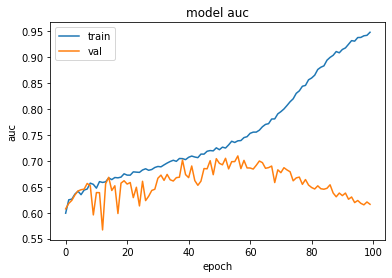

In [70]:
from matplotlib import pyplot as plt
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Trainset, Testset에 대한 ROC 커브 그리고 Confusion Matrix 구해보기
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, confusion_matrix

%matplotlib inline
lstm_train_predicts, lstm_test_predicts = list(), list()
lstm_train_labels, lstm_test_labels = list(), list()

for tr_x, tr_y in death_train_loader:
  batch_predict = death_lstm.predict(tr_x)
  lstm_train_predicts.append(batch_predict)
  lstm_train_labels.append(tr_y)

  batch_predict = death_trans.predict(tr_x)
  trans_train_predicts.append(batch_predict)
  trans_train_labels.append(tr_y)

for test_x, test_y in death_test_loader:
  batch_predict = death_lstm.predict(test_x)
  lstm_test_predicts.append(batch_predict)
  lstm_test_labels.append(test_y)

  batch_predict = death_trans.predict(test_x)
  trans_test_predicts.append(batch_predict)
  trans_test_labels.append(test_y)

lstm_train_predicts = np.concatenate(lstm_train_predicts).reshape(-1, 1)
lstm_train_labels = np.concatenate(lstm_train_labels).astype('int')
lstm_test_predicts = np.concatenate(lstm_test_predicts).reshape(-1, 1)
lstm_test_labels = np.concatenate(lstm_test_labels).astype('int')

trans_train_predicts = np.concatenate(trans_train_predicts).reshape(-1, 1)
trans_train_labels = np.concatenate(trans_train_labels).astype('int')
trans_test_predicts = np.concatenate(trans_test_predicts).reshape(-1, 1)
trans_test_labels = np.concatenate(trans_test_labels).astype('int')


trans_train_roc_x, trans_train_roc_y, _ = roc_curve(trans_train_labels, trans_train_predicts)
trans_train_auroc = roc_auc_score(trans_train_labels, trans_train_predicts)
trans_test_roc_x, trans_test_roc_y, _ = roc_curve(trans_test_labels, trans_test_predicts)
trans_test_auroc = roc_auc_score(trans_test_labels, trans_test_predicts)
# trans_train_roc_x, trans_train_roc_y, _ = roc_curve(trans_train_labels, trans_train_predicts)
# trans_train_auroc = roc_auc_score(trans_train_labels, trans_train_predicts)
# trans_test_roc_x, trans_test_roc_y, _ = roc_curve(trans_test_labels, trans_test_predicts)
# trans_test_auroc = roc_auc_score(trans_test_labels, trans_test_predicts)

lstm_train_roc_x, lstm_train_roc_y, _ = roc_curve(lstm_train_labels, lstm_train_predicts)
lstm_train_auroc = roc_auc_score(lstm_train_labels, lstm_train_predicts)
lstm_test_roc_x, lstm_test_roc_y, _ = roc_curve(lstm_test_labels, lstm_test_predicts)
lstm_test_auroc = roc_auc_score(lstm_test_labels, lstm_test_predicts)
# lstm_train_roc_x, lstm_train_roc_y, _ = roc_curve(lstm_train_labels, lstm_train_predicts)
# lstm_train_auroc = roc_auc_score(lstm_train_labels, lstm_train_predicts)
# lstm_test_roc_x, lstm_test_roc_y, _ = roc_curve(lstm_test_labels, lstm_test_predicts)
# lstm_test_auroc = roc_auc_score(lstm_test_labels, lstm_test_predicts)

plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')


plt.plot(lstm_train_roc_x, lstm_train_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('LSTM Train', lstm_train_auroc))
plt.plot(lstm_test_roc_x, lstm_test_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('LSTM Test', lstm_test_auroc))

plt.legend(fancybox=True)

plt.show()

In [66]:
from keras import backend as k
k.clear_session()

In [ ]:
glyco_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

cepha_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

peni_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

fluoro_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

macro_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
glyco_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = glyco_lstm.fit(glyco_train_loader, validation_data=glyco_test_loader, epochs=num_epochs, verbose=2)

Epoch 1/100
76/76 - 2s - loss: 0.5486 - accuracy: 0.7706 - val_loss: 0.5077 - val_accuracy: 0.7840 - 2s/epoch - 30ms/step
Epoch 2/100
76/76 - 0s - loss: 0.5083 - accuracy: 0.7847 - val_loss: 0.4964 - val_accuracy: 0.7993 - 424ms/epoch - 6ms/step
Epoch 3/100
76/76 - 0s - loss: 0.4993 - accuracy: 0.7977 - val_loss: 0.4851 - val_accuracy: 0.8048 - 451ms/epoch - 6ms/step
Epoch 4/100
76/76 - 0s - loss: 0.4923 - accuracy: 0.7994 - val_loss: 0.4867 - val_accuracy: 0.8044 - 434ms/epoch - 6ms/step
Epoch 5/100
76/76 - 0s - loss: 0.4913 - accuracy: 0.8003 - val_loss: 0.4797 - val_accuracy: 0.8048 - 421ms/epoch - 6ms/step
Epoch 6/100
76/76 - 1s - loss: 0.4881 - accuracy: 0.7998 - val_loss: 0.4787 - val_accuracy: 0.8040 - 586ms/epoch - 8ms/step
Epoch 7/100
76/76 - 1s - loss: 0.4877 - accuracy: 0.8009 - val_loss: 0.4763 - val_accuracy: 0.8053 - 605ms/epoch - 8ms/step
Epoch 8/100
76/76 - 1s - loss: 0.4875 - accuracy: 0.8021 - val_loss: 0.4786 - val_accuracy: 0.8036 - 606ms/epoch - 8ms/step
Epoch 9/10

In [ ]:
cepha_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = cepha_lstm.fit(cepha_train_loader, validation_data=cepha_test_loader, epochs=num_epochs, verbose=2)

Epoch 1/100
71/71 - 2s - loss: 0.4697 - accuracy: 0.8347 - val_loss: 0.4096 - val_accuracy: 0.8517 - 2s/epoch - 33ms/step
Epoch 2/100
71/71 - 0s - loss: 0.4071 - accuracy: 0.8520 - val_loss: 0.4047 - val_accuracy: 0.8517 - 408ms/epoch - 6ms/step
Epoch 3/100
71/71 - 0s - loss: 0.4021 - accuracy: 0.8579 - val_loss: 0.3988 - val_accuracy: 0.8627 - 402ms/epoch - 6ms/step
Epoch 4/100
71/71 - 0s - loss: 0.3959 - accuracy: 0.8626 - val_loss: 0.3943 - val_accuracy: 0.8627 - 402ms/epoch - 6ms/step
Epoch 5/100
71/71 - 0s - loss: 0.3919 - accuracy: 0.8625 - val_loss: 0.3873 - val_accuracy: 0.8631 - 400ms/epoch - 6ms/step
Epoch 6/100
71/71 - 0s - loss: 0.3880 - accuracy: 0.8618 - val_loss: 0.3830 - val_accuracy: 0.8622 - 404ms/epoch - 6ms/step
Epoch 7/100
71/71 - 0s - loss: 0.3864 - accuracy: 0.8641 - val_loss: 0.3829 - val_accuracy: 0.8636 - 411ms/epoch - 6ms/step
Epoch 8/100
71/71 - 0s - loss: 0.3841 - accuracy: 0.8627 - val_loss: 0.3814 - val_accuracy: 0.8636 - 397ms/epoch - 6ms/step
Epoch 9/10

In [ ]:
peni_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = peni_lstm.fit(peni_train_loader, validation_data=peni_test_loader, epochs=num_epochs, verbose=2)

Epoch 1/100
39/39 - 2s - loss: 0.5374 - accuracy: 0.7938 - val_loss: 0.4994 - val_accuracy: 0.7939 - 2s/epoch - 56ms/step
Epoch 2/100
39/39 - 0s - loss: 0.4911 - accuracy: 0.7938 - val_loss: 0.4923 - val_accuracy: 0.7939 - 256ms/epoch - 7ms/step
Epoch 3/100
39/39 - 0s - loss: 0.4846 - accuracy: 0.8043 - val_loss: 0.4821 - val_accuracy: 0.8096 - 300ms/epoch - 8ms/step
Epoch 4/100
39/39 - 0s - loss: 0.4744 - accuracy: 0.8140 - val_loss: 0.4706 - val_accuracy: 0.8145 - 237ms/epoch - 6ms/step
Epoch 5/100
39/39 - 0s - loss: 0.4656 - accuracy: 0.8142 - val_loss: 0.4633 - val_accuracy: 0.8170 - 259ms/epoch - 7ms/step
Epoch 6/100
39/39 - 0s - loss: 0.4676 - accuracy: 0.8138 - val_loss: 0.4632 - val_accuracy: 0.8195 - 278ms/epoch - 7ms/step
Epoch 7/100
39/39 - 0s - loss: 0.4615 - accuracy: 0.8136 - val_loss: 0.4584 - val_accuracy: 0.8195 - 245ms/epoch - 6ms/step
Epoch 8/100
39/39 - 0s - loss: 0.4619 - accuracy: 0.8156 - val_loss: 0.4613 - val_accuracy: 0.8186 - 270ms/epoch - 7ms/step
Epoch 9/10

In [ ]:
fluoro_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = fluoro_lstm.fit(fluoro_train_loader, validation_data=fluoro_test_loader, epochs=num_epochs, verbose=2)

Epoch 1/100
24/24 - 4s - loss: 0.5660 - accuracy: 0.8066 - val_loss: 0.4326 - val_accuracy: 0.8495 - 4s/epoch - 165ms/step
Epoch 2/100
24/24 - 0s - loss: 0.4186 - accuracy: 0.8498 - val_loss: 0.4141 - val_accuracy: 0.8495 - 163ms/epoch - 7ms/step
Epoch 3/100
24/24 - 0s - loss: 0.4122 - accuracy: 0.8498 - val_loss: 0.4135 - val_accuracy: 0.8495 - 157ms/epoch - 7ms/step
Epoch 4/100
24/24 - 0s - loss: 0.4099 - accuracy: 0.8498 - val_loss: 0.4122 - val_accuracy: 0.8495 - 161ms/epoch - 7ms/step
Epoch 5/100
24/24 - 0s - loss: 0.4076 - accuracy: 0.8522 - val_loss: 0.4102 - val_accuracy: 0.8577 - 168ms/epoch - 7ms/step
Epoch 6/100
24/24 - 0s - loss: 0.4046 - accuracy: 0.8569 - val_loss: 0.4048 - val_accuracy: 0.8591 - 157ms/epoch - 7ms/step
Epoch 7/100
24/24 - 0s - loss: 0.3980 - accuracy: 0.8576 - val_loss: 0.4044 - val_accuracy: 0.8605 - 157ms/epoch - 7ms/step
Epoch 8/100
24/24 - 0s - loss: 0.3973 - accuracy: 0.8593 - val_loss: 0.4033 - val_accuracy: 0.8605 - 166ms/epoch - 7ms/step
Epoch 9/1

In [ ]:
macro_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = macro_lstm.fit(macro_train_loader, validation_data=macro_test_loader, epochs=num_epochs, verbose=2)

Epoch 1/100
13/13 - 2s - loss: 0.6112 - accuracy: 0.8409 - val_loss: 0.5292 - val_accuracy: 0.8390 - 2s/epoch - 159ms/step
Epoch 2/100
13/13 - 0s - loss: 0.4691 - accuracy: 0.8409 - val_loss: 0.4327 - val_accuracy: 0.8390 - 103ms/epoch - 8ms/step
Epoch 3/100
13/13 - 0s - loss: 0.4451 - accuracy: 0.8409 - val_loss: 0.4327 - val_accuracy: 0.8390 - 105ms/epoch - 8ms/step
Epoch 4/100
13/13 - 0s - loss: 0.4360 - accuracy: 0.8409 - val_loss: 0.4335 - val_accuracy: 0.8390 - 112ms/epoch - 9ms/step
Epoch 5/100
13/13 - 0s - loss: 0.4328 - accuracy: 0.8409 - val_loss: 0.4311 - val_accuracy: 0.8390 - 108ms/epoch - 8ms/step
Epoch 6/100
13/13 - 0s - loss: 0.4327 - accuracy: 0.8409 - val_loss: 0.4302 - val_accuracy: 0.8390 - 109ms/epoch - 8ms/step
Epoch 7/100
13/13 - 0s - loss: 0.4311 - accuracy: 0.8409 - val_loss: 0.4291 - val_accuracy: 0.8390 - 107ms/epoch - 8ms/step
Epoch 8/100
13/13 - 0s - loss: 0.4301 - accuracy: 0.8409 - val_loss: 0.4275 - val_accuracy: 0.8390 - 103ms/epoch - 8ms/step
Epoch 9/1

In [ ]:
glyco_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_glyco.h5')
cepha_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_cepha.h5')
peni_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_peni.h5')
fluoro_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_fluoro.h5')
macro_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_macro.h5')

In [ ]:
glyco_label=pd.DataFrame(glyco_test['LABEL'])

death_predict=pd.DataFrame(death_lstm.predict(glyco_test_loader))
glyco_predict=pd.DataFrame(glyco_lstm.predict(glyco_test_loader))
cepha_predict=pd.DataFrame(cepha_lstm.predict(glyco_test_loader))
peni_predict=pd.DataFrame(peni_lstm.predict(glyco_test_loader))
fluoro_predict=pd.DataFrame(fluoro_lstm.predict(glyco_test_loader))
macro_predict=pd.DataFrame(macro_lstm.predict(glyco_test_loader))

19/19 [==============================] - 0s 4ms/step


In [ ]:
glyco_total=pd.concat([glyco_label,death_predict,glyco_predict,cepha_predict,peni_predict,fluoro_predict,macro_predict],axis=1)
glyco_total.columns=['label','death_model','glyco_model','cepha_model','peni_model','fluoro_model','macro_model']

In [ ]:
glyco_total

,label,death_model,glyco_model,cepha_model,peni_model,fluoro_model,macro_model
0,1,0.014108,0.223974,0.092540,0.349622,0.311748,0.180778
1,1,0.485061,0.470382,0.522545,0.205113,0.142648,0.128929
2,1,0.356203,0.426065,0.678691,0.231644,0.217998,0.113417
3,1,0.195743,0.163080,0.122726,0.144958,0.110240,0.103486
4,1,0.193229,0.137318,0.205912,0.104218,0.109623,0.064443
...,...,...,...,...,...,...,...
2347,0,0.157966,0.136068,0.127145,0.076348,0.094608,0.062250
2348,0,0.152380,0.152679,0.114211,0.131388,0.103832,0.099097
2349,0,0.262742,0.167690,0.180576,0.158227,0.145779,0.119568
2350,0,0.186726,0.192592,0.222549,0.164990,0.206763,0.104039


In [ ]:
glyco_total.to_csv('glyco_total.csv')

In [ ]:
glyco_total.describe()

,label,death_model,glyco_model,cepha_model,peni_model,fluoro_model,macro_model
count,2352.000000,2352.000000,2352.000000,2352.000000,2352.000000,2352.000000,2352.000000
mean,0.215986,0.196350,0.214887,0.186830,0.198750,0.176921,0.142387
std,0.411592,0.170452,0.158309,0.153455,0.152484,0.155931,0.126896
min,0.000000,0.001662,0.015854,0.000040,0.003022,0.043336,0.002842
25%,0.000000,0.106631,0.149175,0.122726,0.139193,0.108697,0.096551
50%,0.000000,0.164574,0.163080,0.135749,0.144958,0.112443,0.103486
75%,0.000000,0.195743,0.181829,0.198761,0.177399,0.180022,0.125479
max,1.000000,0.999955,0.999038,0.994983,0.988274,0.999859,0.991618


In [ ]:
cepha_label=pd.DataFrame(cepha_test['LABEL'])

death_predict=pd.DataFrame(death_lstm.predict(cepha_test_loader))
glyco_predict=pd.DataFrame(glyco_lstm.predict(cepha_test_loader))
cepha_predict=pd.DataFrame(cepha_lstm.predict(cepha_test_loader))
peni_predict=pd.DataFrame(peni_lstm.predict(cepha_test_loader))
fluoro_predict=pd.DataFrame(fluoro_lstm.predict(cepha_test_loader))
macro_predict=pd.DataFrame(macro_lstm.predict(cepha_test_loader))

18/18 [==============================] - 0s 4ms/step


In [ ]:
cepha_total=pd.concat([cepha_label,death_predict,glyco_predict,cepha_predict,peni_predict,fluoro_predict,macro_predict],axis=1)
cepha_total.columns=['label','death_model','glyco_model','cepha_model','peni_model','fluoro_model','macro_model']

In [ ]:
cepha_total

,label,death_model,glyco_model,cepha_model,peni_model,fluoro_model,macro_model
0,1,0.236570,0.148248,0.279651,0.132168,0.122248,0.086393
1,1,0.410458,0.297525,0.233613,0.239752,0.316624,0.117778
2,1,0.999856,0.895030,0.984093,0.980664,0.999827,0.656816
3,1,0.195743,0.163080,0.122726,0.144958,0.110240,0.103486
4,1,0.237204,0.201668,0.251227,0.167174,0.294863,0.145911
...,...,...,...,...,...,...,...
2187,0,0.077487,0.146791,0.097477,0.153996,0.095492,0.111025
2188,0,0.263328,0.408858,0.108774,0.162515,0.205582,0.099497
2189,0,0.195743,0.163080,0.122726,0.144958,0.110240,0.103486
2190,0,0.195743,0.163080,0.122726,0.144958,0.110240,0.103486


In [ ]:
cepha_total.describe()

,label,death_model,glyco_model,cepha_model,peni_model,fluoro_model,macro_model
count,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000
mean,0.148266,0.153331,0.193897,0.146789,0.186245,0.165484,0.136834
std,0.355445,0.141966,0.128466,0.128426,0.124085,0.127099,0.117513
min,0.000000,0.004505,0.014203,0.000041,0.003430,0.041863,0.002022
25%,0.000000,0.071000,0.145172,0.085396,0.136709,0.108039,0.091566
50%,0.000000,0.128333,0.163080,0.122726,0.144958,0.115422,0.103486
75%,0.000000,0.195743,0.174878,0.166112,0.178013,0.180804,0.127038
max,1.000000,0.999952,0.998940,0.993771,0.988274,0.999858,0.989579


In [ ]:
peni_label=pd.DataFrame(peni_test['LABEL'])

death_predict=pd.DataFrame(death_lstm.predict(peni_test_loader))
glyco_predict=pd.DataFrame(glyco_lstm.predict(peni_test_loader))
cepha_predict=pd.DataFrame(cepha_lstm.predict(peni_test_loader))
peni_predict=pd.DataFrame(peni_lstm.predict(peni_test_loader))
fluoro_predict=pd.DataFrame(fluoro_lstm.predict(peni_test_loader))
macro_predict=pd.DataFrame(macro_lstm.predict(peni_test_loader))

10/10 [==============================] - 0s 4ms/step


In [ ]:
peni_total=pd.concat([peni_label,death_predict,glyco_predict,cepha_predict,peni_predict,fluoro_predict,macro_predict],axis=1)
peni_total.columns=['label','death_model','glyco_model','cepha_model','peni_model','fluoro_model','macro_model']

In [ ]:
peni_total.describe()

,label,death_model,glyco_model,cepha_model,peni_model,fluoro_model,macro_model
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,0.206101,0.185862,0.207560,0.182194,0.188175,0.174800,0.137230
std,0.404670,0.161580,0.148215,0.141028,0.136850,0.147643,0.122632
min,0.000000,0.006523,0.013199,0.000043,0.000992,0.032825,0.001846
25%,0.000000,0.100963,0.147211,0.122726,0.134231,0.107627,0.092442
50%,0.000000,0.141116,0.163080,0.138982,0.144958,0.117527,0.103486
75%,0.000000,0.195743,0.182099,0.195352,0.174253,0.183134,0.127393
max,1.000000,0.999936,0.998780,0.994983,0.988192,0.999842,0.994304


In [ ]:
cepha_total.to_csv('glyco_total.csv')

In [ ]:
diagnoses_icd = pd.merge(left = diagnoses_icd, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')

In [ ]:
sum(death_train['LABEL'])/len(death_train['LABEL'])

0.15838639569908872

모델 저장과
test data로 test( 5개 모델간 차이가 있는지)